In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras import layers, models

# Load MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Flatten images
x_train = x_train.reshape(60000, -1).astype("float32") / 255.0
x_test  = x_test.reshape(10000, -1).astype("float32") / 255.0


#### Using a PCA to reduce input dimensionality

In [2]:
pca = PCA(n_components=300)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

#### Creating an MLP

In [3]:
# Basic MLP
model = models.Sequential([
    layers.Input(shape=(300,)),
    layers.Dense(150, activation="relu"),
    layers.Dense(75, activation="relu"),
    layers.Dense(10, activation="softmax"),
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 150)                 │          45,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 75)                  │          11,325 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             760 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,235 (223.57 KB)

 Trainable params: 57,235 (223.57 KB)

 Non-trainable params: 0 (0.00 B)

#### Training an MLP

In [4]:
model.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.1)

test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8871 - loss: 0.4093 - val_accuracy: 0.9647 - val_loss: 0.1280
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9644 - loss: 0.1208 - val_accuracy: 0.9732 - val_loss: 0.0970
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9792 - loss: 0.0727 - val_accuracy: 0.9733 - val_loss: 0.0815
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9876 - loss: 0.0464 - val_accuracy: 0.9760 - val_loss: 0.0807
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9930 - loss: 0.0290 - val_accuracy: 0.9765 - val_loss: 0.0772
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9749 - loss: 0.0798  
Test accuracy: 0.9749000072479248


In [5]:
W1 = model.layers[0].weights[0]
W2 = model.layers[1].weights[0]
W3 = model.layers[2].weights[0]

#### Sparse mask function to prune weights from the model (Update epsilon to change sparsity)

In [6]:
def create_sparse_mask(shape, epsilon=11):  
    # SET paper uses epsilon = 11
    fan_in = shape[0]
    prob = epsilon / fan_in
    return np.random.rand(*shape) < prob

In [7]:
mask1 = create_sparse_mask(W1.shape)
mask2 = create_sparse_mask(W2.shape)
mask3 = create_sparse_mask(W3.shape)

print(mask3)

[[False  True False False False  True False False False False]
 [ True False False False False False  True False False  True]
 [False False False False  True False  True False  True False]
 [False  True  True False False False False False False False]
 [False  True False False False  True  True False False False]
 [ True False  True False False False False False False  True]
 [ True False False False  True False False  True False False]
 [ True False False  True  True False False False False False]
 [ True False False False False False False False False  True]
 [False False False  True False False False False  True False]
 [False False False False False False False  True  True False]
 [False  True False False False False  True False False False]
 [ True False False  True False False False False False False]
 [False False False False False  True False  True False False]
 [False False False False False False False  True False  True]
 [False False False False False False False False False

In [8]:
W1.assign(W1 * mask1)
W2.assign(W2 * mask2)
W3.assign(W3 * mask3)

<tf.Tensor: shape=(75, 10), dtype=float32, numpy=
array([[ 0.        , -0.08630943,  0.        , -0.        ,  0.        ,
         0.16992512,  0.        , -0.        , -0.        ,  0.        ],
       [ 0.24080096,  0.        ,  0.        ,  0.        , -0.        ,
        -0.        ,  0.32242352, -0.        , -0.        , -0.2959259 ],
       [ 0.        ,  0.        , -0.        ,  0.        , -0.05220577,
         0.        , -0.22980049,  0.        ,  0.30393007, -0.        ],
       [-0.        , -0.21986395,  0.4082224 , -0.        , -0.        ,
         0.        , -0.        , -0.        , -0.        ,  0.        ],
       [-0.        ,  0.31456512, -0.        ,  0.        , -0.        ,
         0.11967237, -0.41739643,  0.        ,  0.        , -0.        ],
       [ 0.22660808,  0.        ,  0.38664582,  0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        ,  0.059622  ],
       [-0.38320997, -0.        ,  0.        , -0.        , -0.11273

#### Training the sparse model (Realized that the optimizer would still update the 0 weights so I had to make a custom training loop, see further down)

In [9]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
model.fit(x_train, y_train, epochs=5, batch_size=128, validation_split=0.1)

test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8905 - loss: 0.4617 - val_accuracy: 0.9613 - val_loss: 0.1415
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9618 - loss: 0.1311 - val_accuracy: 0.9713 - val_loss: 0.0994
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9770 - loss: 0.0807 - val_accuracy: 0.9727 - val_loss: 0.0916
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9851 - loss: 0.0522 - val_accuracy: 0.9738 - val_loss: 0.0847
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9905 - loss: 0.0342 - val_accuracy: 0.9767 - val_loss: 0.0848
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9747 - loss: 0.0845  
Test accuracy: 0.9746999740600586


#### Found out that the zero count was way too high (AKA the zero weights (non connections) get updated during regular training)

In [10]:
W1_after = model.layers[0].weights[0].numpy()
W2_after = model.layers[1].weights[0].numpy()
W3_after = model.layers[2].weights[0].numpy()

print("Non-zero connections in W1:", np.count_nonzero(W1_after))
print("Non-zero connections in W2:", np.count_nonzero(W2_after))
print("Non-zero connections in W3:", np.count_nonzero(W3_after))

Non-zero connections in W1: 45000
Non-zero connections in W2: 11250
Non-zero connections in W3: 750


#### Created a custom training loop

In [11]:
batch_size = 128
N = x_train.shape[0]

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.shuffle(N).batch(batch_size)

optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()


In [12]:
@tf.function
def train_step(x_batch, y_batch):
    with tf.GradientTape() as tape:
        preds = model(x_batch)
        loss = loss_fn(y_batch, preds)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Apply masks
    W1.assign(W1 * mask1)
    W2.assign(W2 * mask2)
    W3.assign(W3 * mask3)

    # accuracy
    pred_classes = tf.argmax(preds, axis=1)
    y_batch = tf.cast(y_batch, tf.int64)
    acc = tf.reduce_mean(tf.cast(pred_classes == y_batch, tf.float32))

    return float(loss), acc

In [13]:
for epoch in range(10):
    bar = tqdm(dataset)
    for x_batch, y_batch in bar:
        t0 = time.time()
        loss_value, acc_value = train_step(x_batch, y_batch)
        dt = time.time() - t0
        bar.set_postfix({
            "dt": f"{dt:.4f}s",
            "loss": f"{loss_value:.4f}",
            "acc": f"{acc_value:.4f}"
        })
    print(f"Epoch {epoch+1} done")

100%|██████████████████████████████████████████| 469/469 [00:02<00:00, 220.10it/s, dt=0.2242s, loss=0.9297, acc=0.7292]


Epoch 1 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 353.59it/s, dt=0.0015s, loss=0.3746, acc=0.8958]


Epoch 2 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 353.58it/s, dt=0.0015s, loss=0.4192, acc=0.8333]


Epoch 3 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 338.99it/s, dt=0.0010s, loss=0.4094, acc=0.8438]


Epoch 4 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 347.67it/s, dt=0.0020s, loss=0.3845, acc=0.8958]


Epoch 5 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 346.38it/s, dt=0.0015s, loss=0.1318, acc=0.9792]


Epoch 6 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 346.90it/s, dt=0.0015s, loss=0.2712, acc=0.9167]


Epoch 7 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 345.88it/s, dt=0.0015s, loss=0.3372, acc=0.9375]


Epoch 8 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 343.59it/s, dt=0.0015s, loss=0.3005, acc=0.8854]


Epoch 9 done


100%|██████████████████████████████████████████| 469/469 [00:01<00:00, 343.97it/s, dt=0.0015s, loss=0.2683, acc=0.9479]

Epoch 10 done


#### Now we truly have sparsity :)

In [14]:
W1_after = model.layers[0].weights[0].numpy()
W2_after = model.layers[1].weights[0].numpy()
W3_after = model.layers[2].weights[0].numpy()

print("Non-zero connections in W1:", np.count_nonzero(W1_after))
print("Non-zero connections in W2:", np.count_nonzero(W2_after))
print("Non-zero connections in W3:", np.count_nonzero(W3_after))

Non-zero connections in W1: 1697
Non-zero connections in W2: 778
Non-zero connections in W3: 111


#### Accuracy is pretty bad since it is randomly deciding which connections matter. It could even prune edges towards the output so that a single output might have 0 connections XD which is not good ofc
#### This is where the regrow comes in (Further down)

In [15]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9139 - loss: 0.2930  
Test accuracy: 0.9139000177383423


#### Drawing the network (please only use on small models XD)

In [16]:
def draw_layer_connections(W, layer_in_size, layer_out_size, title="Layer connections"):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(title)
    ax.axis("off")

    # Positions of neurons
    x_in, x_out = 0, 1
    y_in = np.linspace(0, 1, layer_in_size)
    y_out = np.linspace(0, 1, layer_out_size)

    # Draw neurons
    ax.scatter([x_in] * layer_in_size, y_in, s=30, color="blue")
    ax.scatter([x_out] * layer_out_size, y_out, s=30, color="red")

    # Draw connections
    for i in range(layer_in_size):
        for j in range(layer_out_size):
            if W[i, j] != 0:  # check active connection
                ax.plot([x_in, x_out], [y_in[i], y_out[j]],
                        linewidth=0.5, color="gray")

    plt.show()


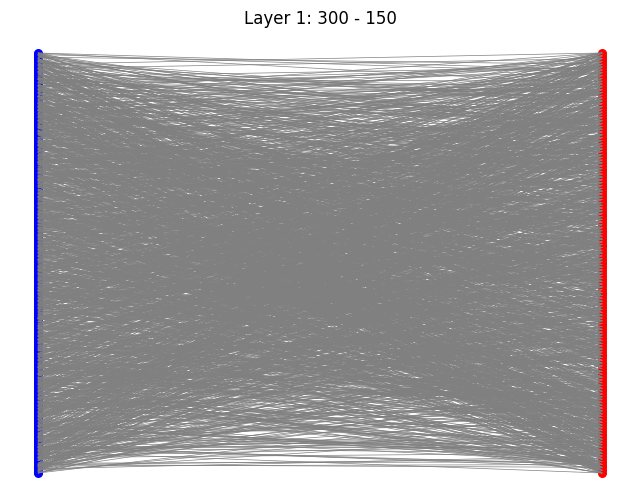

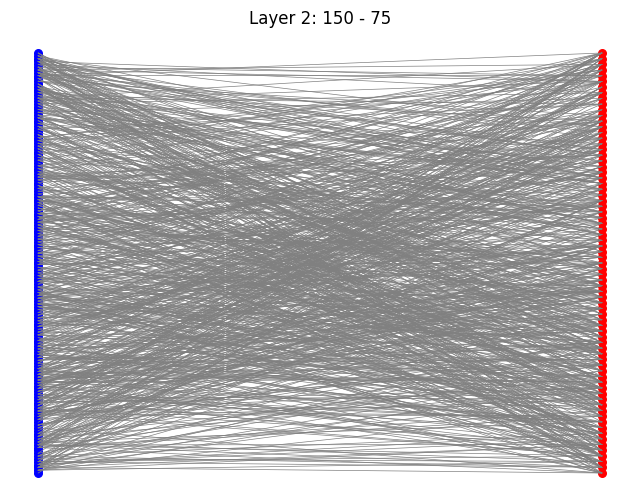

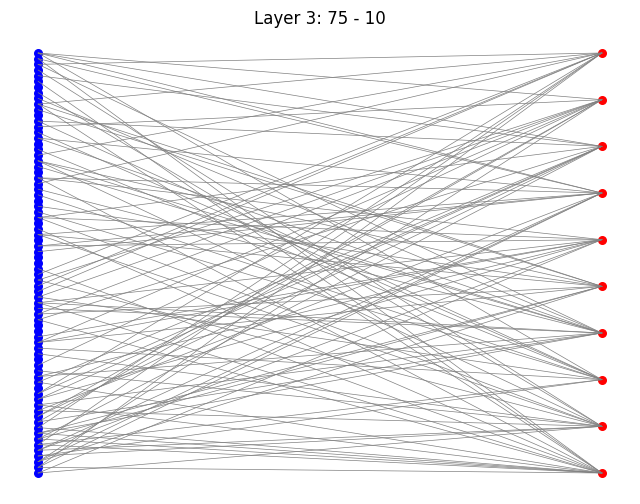

In [17]:
W1_after = model.layers[0].get_weights()[0]
W2_after = model.layers[1].get_weights()[0]
W3_after = model.layers[2].get_weights()[0]

draw_layer_connections(W1_after, 300, 150, "Layer 1: 300 - 150")
draw_layer_connections(W2_after, 150, 75, "Layer 2: 150 - 75")
draw_layer_connections(W3_after, 75, 10, "Layer 3: 75 - 10")


In [18]:
def prune(Weight, Mask):
    W = Weight.numpy()
    flat_W = W.flatten()
    mask_flat = Mask.flatten()
    
    nz_indices = np.where(Mask.flatten())[0]
    nz_values = flat_W[nz_indices]
    
    sorted_idx = np.argsort(np.abs(nz_values))

    k = int(zeta * len(nz_indices))
    k = max(1, min(k, len(nz_indices)))
    
    prune_indices = nz_indices[sorted_idx[:k]]

    rows = prune_indices // W.shape[1]
    cols = prune_indices % W.shape[1]

    W[rows, cols] = 0
    Mask[rows, cols] = False
    
    Weight.assign(W)

    return k

In [19]:
def regrow(Weight, Mask, k):
    W = Weight.numpy()
    mask_flat = Mask.flatten()
    
    # Use mask to find dead edges
    zero_idx = np.where(mask_flat == False)[0]

    k = min(k, len(zero_idx))
    if k == 0:
        return
        
    # Randomly select the index to regrow
    grow_idx = np.random.choice(zero_idx, size=k, replace=False)

    rows = grow_idx // W.shape[1]
    cols = grow_idx % W.shape[1]

    # Random init of new weights
    W[rows, cols] = np.random.normal(0, 0.1, size=k)

    Mask[rows, cols] = True
    Weight.assign(W)

100%|████████████████████████████████████| 469/469 [00:01<00:00, 350.70it/s, dt=0.0015s, loss=0.2924, batch_acc=0.8542]


Epoch 1: accuracy=0.9155
Epoch 1 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 347.32it/s, dt=0.0015s, loss=0.2336, batch_acc=0.9479]


Epoch 2: accuracy=0.9056
Epoch 2 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 345.25it/s, dt=0.0020s, loss=0.3610, batch_acc=0.8854]


Epoch 3: accuracy=0.9146
Epoch 3 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 334.16it/s, dt=0.0025s, loss=0.3283, batch_acc=0.9062]


Epoch 4: accuracy=0.9176
Epoch 4 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 324.02it/s, dt=0.0020s, loss=0.3301, batch_acc=0.9167]


Epoch 5: accuracy=0.9190
Epoch 5 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 327.82it/s, dt=0.0015s, loss=0.2081, batch_acc=0.9479]


Epoch 6: accuracy=0.9205
Epoch 6 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 344.34it/s, dt=0.0010s, loss=0.2323, batch_acc=0.9062]


Epoch 7: accuracy=0.9217
Epoch 7 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 346.82it/s, dt=0.0015s, loss=0.2865, batch_acc=0.9375]


Epoch 8: accuracy=0.9234
Epoch 8 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 345.35it/s, dt=0.0010s, loss=0.2842, batch_acc=0.9271]


Epoch 9: accuracy=0.9235
Epoch 9 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 347.03it/s, dt=0.0015s, loss=0.2065, batch_acc=0.9375]


Epoch 10: accuracy=0.9240
Epoch 10 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 327.02it/s, dt=0.0015s, loss=0.2719, batch_acc=0.9375]


Epoch 11: accuracy=0.9251
Epoch 11 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 317.91it/s, dt=0.0020s, loss=0.3212, batch_acc=0.9062]


Epoch 12: accuracy=0.9258
Epoch 12 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 335.30it/s, dt=0.0020s, loss=0.2975, batch_acc=0.9062]


Epoch 13: accuracy=0.9260
Epoch 13 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 336.08it/s, dt=0.0020s, loss=0.1349, batch_acc=0.9688]


Epoch 14: accuracy=0.9262
Epoch 14 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 342.31it/s, dt=0.0015s, loss=0.3396, batch_acc=0.9271]


Epoch 15: accuracy=0.9277
Epoch 15 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 338.49it/s, dt=0.0015s, loss=0.2231, batch_acc=0.9375]


Epoch 16: accuracy=0.9277
Epoch 16 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 342.45it/s, dt=0.0020s, loss=0.1605, batch_acc=0.9583]


Epoch 17: accuracy=0.9275
Epoch 17 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 329.44it/s, dt=0.0015s, loss=0.2168, batch_acc=0.9271]


Epoch 18: accuracy=0.9278
Epoch 18 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 342.18it/s, dt=0.0015s, loss=0.1525, batch_acc=0.9583]


Epoch 19: accuracy=0.9286
Epoch 19 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 343.95it/s, dt=0.0015s, loss=0.1884, batch_acc=0.9688]


Epoch 20: accuracy=0.9287
Epoch 20 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 339.45it/s, dt=0.0015s, loss=0.1760, batch_acc=0.9583]


Epoch 21: accuracy=0.9291
Epoch 21 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 340.95it/s, dt=0.0015s, loss=0.2554, batch_acc=0.9271]


Epoch 22: accuracy=0.9297
Epoch 22 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 343.57it/s, dt=0.0015s, loss=0.2400, batch_acc=0.9062]


Epoch 23: accuracy=0.9301
Epoch 23 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 342.56it/s, dt=0.0015s, loss=0.2431, batch_acc=0.9375]


Epoch 24: accuracy=0.9304
Epoch 24 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 339.22it/s, dt=0.0020s, loss=0.2559, batch_acc=0.9271]


Epoch 25: accuracy=0.9313
Epoch 25 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 326.90it/s, dt=0.0020s, loss=0.2040, batch_acc=0.9479]


Epoch 26: accuracy=0.9315
Epoch 26 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 339.22it/s, dt=0.0015s, loss=0.2223, batch_acc=0.9271]


Epoch 27: accuracy=0.9312
Epoch 27 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 339.49it/s, dt=0.0015s, loss=0.1459, batch_acc=0.9583]


Epoch 28: accuracy=0.9313
Epoch 28 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 342.09it/s, dt=0.0020s, loss=0.2498, batch_acc=0.9583]


Epoch 29: accuracy=0.9322
Epoch 29 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 342.46it/s, dt=0.0015s, loss=0.1697, batch_acc=0.9271]


Epoch 30: accuracy=0.9320
Epoch 30 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 337.28it/s, dt=0.0020s, loss=0.3191, batch_acc=0.8958]


Epoch 31: accuracy=0.9326
Epoch 31 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 342.43it/s, dt=0.0020s, loss=0.1781, batch_acc=0.9375]


Epoch 32: accuracy=0.9330
Epoch 32 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 306.85it/s, dt=0.0015s, loss=0.3368, batch_acc=0.9062]


Epoch 33: accuracy=0.9327
Epoch 33 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 338.62it/s, dt=0.0015s, loss=0.1398, batch_acc=0.9479]


Epoch 34: accuracy=0.9328
Epoch 34 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 341.96it/s, dt=0.0015s, loss=0.1911, batch_acc=0.9271]


Epoch 35: accuracy=0.9329
Epoch 35 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 343.59it/s, dt=0.0020s, loss=0.2005, batch_acc=0.9375]


Epoch 36: accuracy=0.9331
Epoch 36 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 338.12it/s, dt=0.0015s, loss=0.2642, batch_acc=0.9062]


Epoch 37: accuracy=0.9330
Epoch 37 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 341.19it/s, dt=0.0015s, loss=0.2692, batch_acc=0.9062]


Epoch 38: accuracy=0.9335
Epoch 38 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 339.50it/s, dt=0.0015s, loss=0.1999, batch_acc=0.9375]


Epoch 39: accuracy=0.9337
Epoch 39 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 334.72it/s, dt=0.0015s, loss=0.2146, batch_acc=0.9167]


Epoch 40: accuracy=0.9343
Epoch 40 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 329.45it/s, dt=0.0015s, loss=0.2179, batch_acc=0.9479]


Epoch 41: accuracy=0.9342
Epoch 41 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 340.95it/s, dt=0.0015s, loss=0.3110, batch_acc=0.8854]


Epoch 42: accuracy=0.9322
Epoch 42 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 338.49it/s, dt=0.0015s, loss=0.2858, batch_acc=0.9167]


Epoch 43: accuracy=0.9339
Epoch 43 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 337.28it/s, dt=0.0020s, loss=0.1054, batch_acc=0.9688]


Epoch 44: accuracy=0.9338
Epoch 44 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 340.59it/s, dt=0.0015s, loss=0.1728, batch_acc=0.9479]


Epoch 45: accuracy=0.9348
Epoch 45 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 340.34it/s, dt=0.0015s, loss=0.1143, batch_acc=0.9688]


Epoch 46: accuracy=0.9348
Epoch 46 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 339.85it/s, dt=0.0015s, loss=0.1775, batch_acc=0.9479]


Epoch 47: accuracy=0.9348
Epoch 47 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 303.86it/s, dt=0.0015s, loss=0.2958, batch_acc=0.9271]


Epoch 48: accuracy=0.9350
Epoch 48 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 342.11it/s, dt=0.0015s, loss=0.1984, batch_acc=0.9271]


Epoch 49: accuracy=0.9352
Epoch 49 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 348.61it/s, dt=0.0015s, loss=0.1858, batch_acc=0.9375]


Epoch 50: accuracy=0.9338
Epoch 50 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 331.18it/s, dt=0.0020s, loss=0.2569, batch_acc=0.9479]


Epoch 51: accuracy=0.9350
Epoch 51 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 341.45it/s, dt=0.0020s, loss=0.2401, batch_acc=0.9271]


Epoch 52: accuracy=0.9356
Epoch 52 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 336.67it/s, dt=0.0015s, loss=0.3058, batch_acc=0.9167]


Epoch 53: accuracy=0.9356
Epoch 53 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 336.42it/s, dt=0.0015s, loss=0.2370, batch_acc=0.9375]


Epoch 54: accuracy=0.9360
Epoch 54 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 338.00it/s, dt=0.0015s, loss=0.1736, batch_acc=0.9583]


Epoch 55: accuracy=0.9359
Epoch 55 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 330.03it/s, dt=0.0015s, loss=0.1904, batch_acc=0.9167]


Epoch 56: accuracy=0.9359
Epoch 56 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 336.53it/s, dt=0.0010s, loss=0.2274, batch_acc=0.9062]


Epoch 57: accuracy=0.9359
Epoch 57 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 338.27it/s, dt=0.0015s, loss=0.1920, batch_acc=0.9688]


Epoch 58: accuracy=0.9364
Epoch 58 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 340.07it/s, dt=0.0020s, loss=0.2698, batch_acc=0.9167]


Epoch 59: accuracy=0.9359
Epoch 59 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 341.34it/s, dt=0.0015s, loss=0.1353, batch_acc=0.9479]


Epoch 60: accuracy=0.9361
Epoch 60 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 341.58it/s, dt=0.0020s, loss=0.1918, batch_acc=0.9271]


Epoch 61: accuracy=0.9369
Epoch 61 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 340.21it/s, dt=0.0010s, loss=0.2207, batch_acc=0.9479]


Epoch 62: accuracy=0.9369
Epoch 62 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 327.25it/s, dt=0.0015s, loss=0.2616, batch_acc=0.9167]


Epoch 63: accuracy=0.9370
Epoch 63 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 341.83it/s, dt=0.0015s, loss=0.1799, batch_acc=0.9688]


Epoch 64: accuracy=0.9366
Epoch 64 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 341.79it/s, dt=0.0015s, loss=0.3923, batch_acc=0.9167]


Epoch 65: accuracy=0.9367
Epoch 65 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 340.58it/s, dt=0.0015s, loss=0.2400, batch_acc=0.9375]


Epoch 66: accuracy=0.9367
Epoch 66 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 339.10it/s, dt=0.0020s, loss=0.3107, batch_acc=0.9167]


Epoch 67: accuracy=0.9370
Epoch 67 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 334.52it/s, dt=0.0020s, loss=0.2577, batch_acc=0.9271]


Epoch 68: accuracy=0.9373
Epoch 68 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 332.85it/s, dt=0.0015s, loss=0.1781, batch_acc=0.9479]


Epoch 69: accuracy=0.9375
Epoch 69 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 323.98it/s, dt=0.0015s, loss=0.1492, batch_acc=0.9375]


Epoch 70: accuracy=0.9380
Epoch 70 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 337.52it/s, dt=0.0015s, loss=0.3009, batch_acc=0.8958]


Epoch 71: accuracy=0.9377
Epoch 71 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 336.20it/s, dt=0.0015s, loss=0.2852, batch_acc=0.9167]


Epoch 72: accuracy=0.9379
Epoch 72 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 313.00it/s, dt=0.0015s, loss=0.1237, batch_acc=0.9688]


Epoch 73: accuracy=0.9381
Epoch 73 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 339.11it/s, dt=0.0010s, loss=0.2262, batch_acc=0.9271]


Epoch 74: accuracy=0.9368
Epoch 74 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 336.19it/s, dt=0.0015s, loss=0.2142, batch_acc=0.9271]


Epoch 75: accuracy=0.9378
Epoch 75 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 340.83it/s, dt=0.0015s, loss=0.1219, batch_acc=0.9792]


Epoch 76: accuracy=0.9378
Epoch 76 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 328.53it/s, dt=0.0015s, loss=0.1073, batch_acc=0.9479]


Epoch 77: accuracy=0.9382
Epoch 77 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 337.29it/s, dt=0.0015s, loss=0.2130, batch_acc=0.9271]


Epoch 78: accuracy=0.9389
Epoch 78 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 337.77it/s, dt=0.0015s, loss=0.2551, batch_acc=0.9167]


Epoch 79: accuracy=0.9379
Epoch 79 done


100%|████████████████████████████████████| 469/469 [00:01<00:00, 340.23it/s, dt=0.0015s, loss=0.2982, batch_acc=0.8958]


Epoch 80: accuracy=0.9392
Epoch 80 done
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9271 - loss: 0.2351  
Test accuracy: 0.9271000027656555


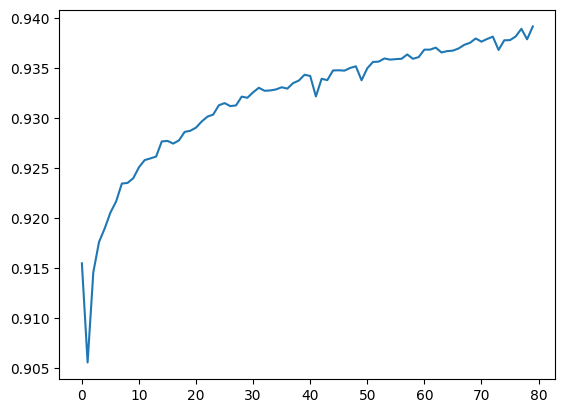

In [20]:
zeta = 0.3
acc_thresh = 0.943
N = 8
acc = []

for epoch in range(80):
    correct_total = 0
    total_samples = 0
    bar = tqdm(dataset)

    for x_batch, y_batch in bar:
        t0 = time.time()
        loss_value, acc_value = train_step(x_batch, y_batch)
        dt = time.time() - t0
        
        batch_size = x_batch.shape[0]
        correct_total += acc_value.numpy() * batch_size
        total_samples += batch_size
        bar.set_postfix({
            "dt": f"{dt:.4f}s",
            "loss": f"{loss_value:.4f}",
            "batch_acc": f"{acc_value:.4f}"
        })

    epoch_acc = correct_total / total_samples
    acc.append(epoch_acc)
    print(f"Epoch {epoch+1}: accuracy={epoch_acc:.4f}")

    if epoch_acc >= acc_thresh:
        print("Reached target accuracy")
        break

    # Every N epochs: prune and regrow
    if epoch % N == 0:
        k = prune(W1, mask1); regrow(W1, mask1, k)
        k = prune(W2, mask2); regrow(W2, mask2, k)
        k = prune(W3, mask3); regrow(W3, mask3, k)

    print(f"Epoch {epoch+1} done")

# draw_layer_connections(W1, 300, 150, "Layer 1: 300 - 150")
# draw_layer_connections(W2, 150, 75, "Layer 2: 150 - 75")
# draw_layer_connections(W3, 75, 10, "Layer 3: 75 - 10")

plt.plot(acc)
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)